# Model interpretation for Pretrained ResNet Model

This notebook demonstrates how to apply model interpretability algorithms on pretrained ResNet model using a handpicked images and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithms that we use in this notebook are Integrated Gradients (w/o noise tunnel) and GradientShap. Noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.

In [139]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz


Loads pretrained Resnet model and sets it to eval mode

In [140]:
model = models.resnet18(pretrained=True)
model = model.eval()

Downloads the classes for ImageNet dataset and reads them into memory

In [141]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
    
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Transform and normalize the image

In [150]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('img/resnet/ILSVRC2012_test_00000019.JPEG')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)


Predict the class of the input image

In [151]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

predicted_label = idx_to_labels[str(pred_label_idx.squeeze().item())][1]

This function allows us to generate random images by choosing random values for each pixel between input values provided as start and end.

In [152]:
def random_image(input):
    return 255.0 * torch.randn(input.shape, dtype=input.dtype, device=input.device)


This function is used to visualize the image and corresponding attributions by overlaying the latter on the image.

In [153]:
def visualize(attributions):
    img_overlay = viz.visualize_image(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      clip_above_percentile=99,
                                      clip_below_percentile=0,
                                      overlay=True,
                                      mask_mode=True)
    stacked_images = torch.stack([transformed_img, torch.Tensor(img_overlay).permute(2,0,1)])
    image_grid = torchvision.utils.make_grid(stacked_images, nrow=5, padding=4)
    plt.figure(figsize = (50, 10))
    plt.imshow((image_grid.permute(1,2,0).detach().numpy() * 255).astype(np.uint8))
    plt.show()


Compute attributions using Integrated Gradients and visualizing them on the image.

Predicted: chickadee ( 0.8355506062507629 )


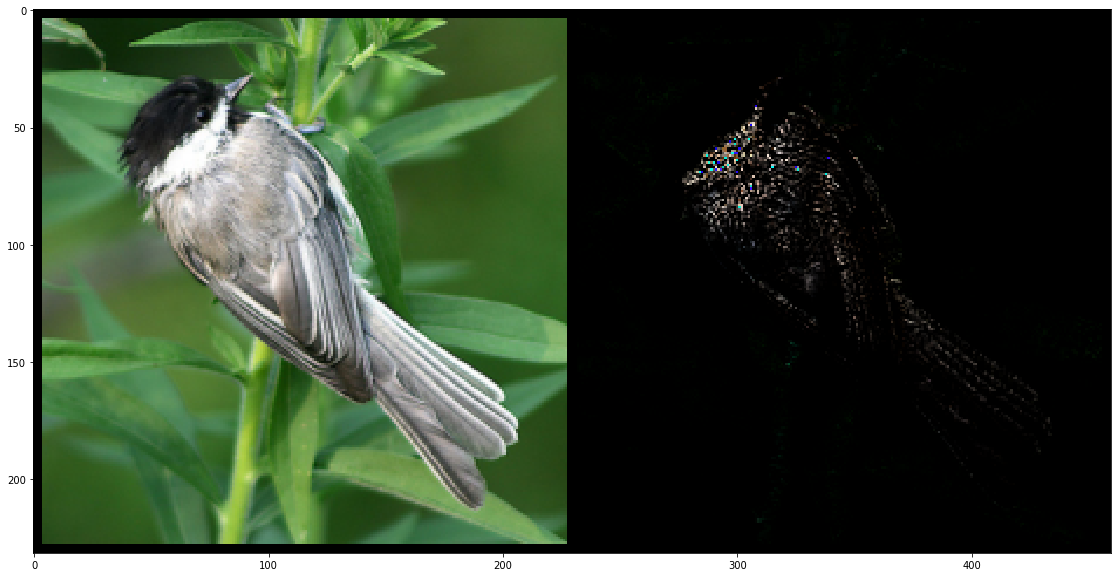

In [154]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig, delta = integrated_gradients.attribute(input, target=pred_label_idx)
visualize(attributions_ig)

Computes attributions using Integrated Gradients and smoothes them across multiple images generated using noise tunnel.

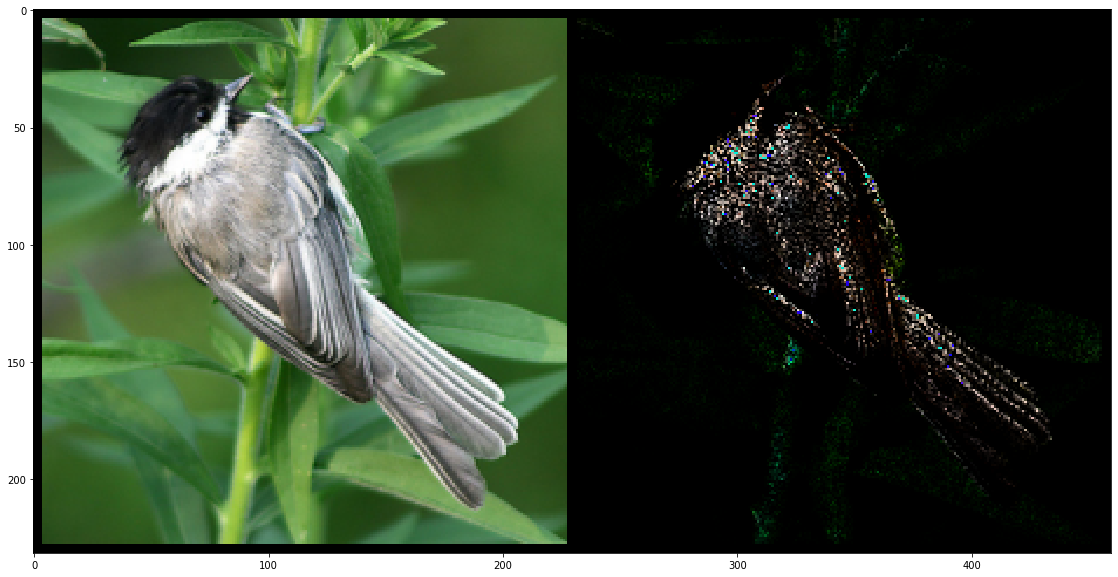

In [155]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt, delta = noise_tunnel.attribute(input, n_samples=5, nt_type='smoothgrad', target=pred_label_idx)
visualize(attributions_ig_nt)


Computes GradientShap using a simple reference distribution of two images.

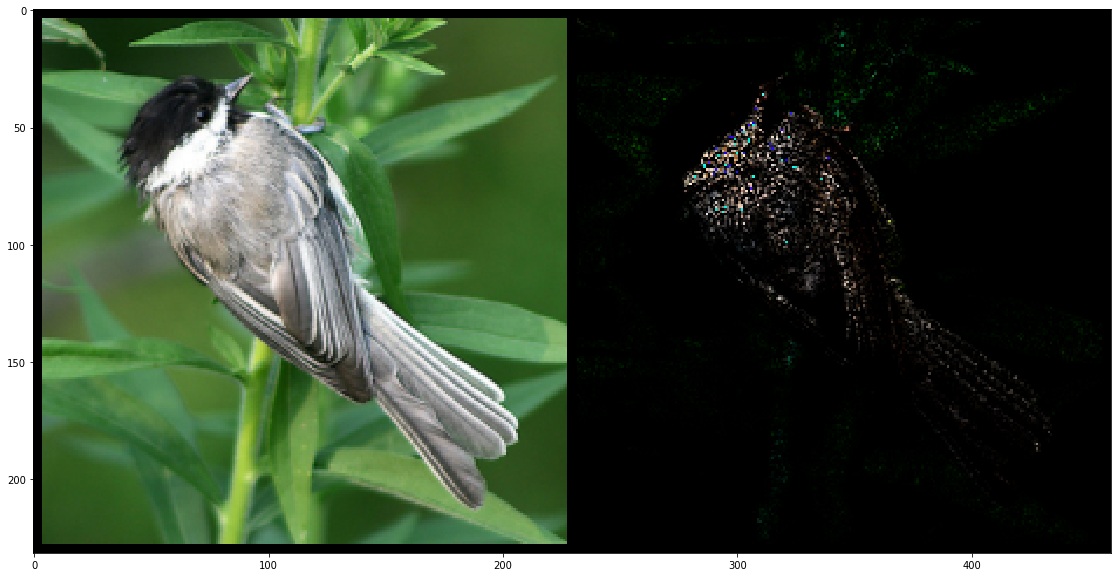

In [156]:
torch.manual_seed(123)
np.random.seed(123)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, random_image(input)])

attributions_gs, delta = gradient_shap.attribute(input,
                                                 n_samples=15,
                                                 stdevs=0.0001,
                                                 baselines=rand_img_dist,
                                                 target=pred_label_idx)
visualize(attributions_gs)